# Diagnostics figures

In [1]:
# General stuff
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
from tqdm import tqdm
from datetime import date
import plotly.express as px
import itertools
from scipy.spatial import Delaunay
from matplotlib import colors
from matplotlib.collections import LineCollection

# Plotly stuff
import kaleido
import plotly
from plotly.subplots import make_subplots

In [47]:
Models = ['IMAGE 3.2',              # 
          'PROMETHEUS 1.2',         # 
          'OSeMBE v1.0.0',          # country-level (sum?)
          'REMIND 2.1',             # 
          'WITCH 5.1',              # 
          'Euro-Calliope 2.0',      # Country-level (sum?)
          'MEESA v1.1',             # 
          'TIAM-ECN 1.2',           # 
          'MESSAGEix-GLOBIOM 1.2',  # 
          'PRIMES 2022'
          ]

Models_noec = ['IMAGE 3.2',              # 
          'PROMETHEUS 1.2',         # 
          'OSeMBE v1.0.0',          # country-level (sum?)
          'REMIND 2.1',             # 
          'WITCH 5.1',              # 
          #'Euro-Calliope 2.0',      # Country-level (sum?)
          'MEESA v1.1',             # 
          'TIAM-ECN 1.2',           # 
          'MESSAGEix-GLOBIOM 1.2',  # 
          'PRIMES 2022'
          ]

scenarios = ['DIAG-Base',
             'DIAG-NPI',
             'DIAG-C400-lin',
             'DIAG-C80-gr5',
             'DIAG-C0to80-gr5',
             'DIAG-NZero',
             'DIAG-C400-lin-LimBio',
             'DIAG-C400-lin-LimCCS',
             'DIAG-C400-lin-LimNuclear',
             'DIAG-C400-lin-HighVRE',
             'DIAG-C400-lin-HighElectrification',
             'DIAG-C400-lin-HighH2',
             'DIAG-C400-lin-ResidualFossil',
             'DIAG-C400-lin-HighEff']

scenarios_nobasenpi = scenarios[2:]

ModelCols = ["lightskyblue", #"turquoise", #"#c0c0c0",
             "goldenrod", #"turquoise"
             "firebrick", #"#ff00ff",
             "tomato", #"#800080",
             "forestgreen", #"#a52a2a",
             "darkgrey", #"goldenrod",
             "magenta", #"tomato",
             "royalblue", # steelblue #"#4682b4",
             "purple",
             "palegreen"]#"#228b22"]
ModelCols_noec = ["lightskyblue", #"turquoise", #"#c0c0c0",
             "goldenrod", #"turquoise"
             "firebrick", #"#ff00ff",
             "tomato", #"#800080",
             "forestgreen", #"#a52a2a",
             #"darkgrey", #"goldenrod",
             "magenta", #"tomato",
             "royalblue", # steelblue #"#4682b4",
             "purple",
             "palegreen"]#"#228b22"]

Models_raw = ["IMAGE", "PROMETHEUS", "OSeMBE", "REMIND-MAgPIE", "WITCH", "Euro-Calliope", "MEESA", "TIAM-ECN", "MESSAGE", "PRIMES"]
Models_raw_noec = ["IMAGE", "PROMETHEUS", "OSeMBE", "REMIND-MAgPIE", "WITCH", "MEESA", "TIAM-ECN", "MESSAGE", "PRIMES"] 

In [3]:
path_data = Path("X:/user/dekkerm/Projects/ECEMF/WP1/Data")

## Read

In [4]:
df_total = pd.read_csv(path_data / "EuropeanData" / (Models[0] + ".csv"))
for m_i in range(1, len(Models)):
    df = pd.read_csv(path_data / "EuropeanData" / (Models[m_i] + ".csv"))
    df_total = pd.concat([df_total, df])
df_total = df_total.reset_index(drop=True)
df_total = df_total[['Model', 'Scenario', 'Variable', '2005', '2010', '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2060', '2070', '2080', '2090', '2100']]
df = df_total.melt(id_vars=["Variable", "Scenario", "Model"], var_name="Time", value_name="Value")

val = np.copy(df.Value)
val[(df.Scenario == "DIAG-C400-lin-ResidualFossil") & (df.Model == "IMAGE 3.2")] = np.nan
val[(df.Scenario == "DIAG-C400-lin-HighH2") & (df.Model == "IMAGE 3.2")] = np.nan
df.Value = val

df['Time'] = np.array(df['Time']).astype(int)
dfdummy = df.set_index(['Variable', "Scenario", "Model", 'Time'])
XRe = xr.Dataset.from_dataframe(dfdummy)
XRe = XRe.reindex(Time=np.arange(2005, 2101))
XRe = XRe.interpolate_na(dim="Time", method="linear")

In [5]:
df_total = pd.read_csv(path_data / "WorldData" / (Models[0] + ".csv"))
for m_i in range(1, len(Models)):
    df = pd.read_csv(path_data / "WorldData" / (Models[m_i] + ".csv"))
    df_total = pd.concat([df_total, df])
df_total = df_total.reset_index(drop=True)
df_total = df_total[['Model', 'Scenario', 'Variable', '2005', '2010', '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2060', '2070', '2080', '2090', '2100']]
df = df_total.melt(id_vars=["Variable", "Scenario", "Model"], var_name="Time", value_name="Value")
df['Time'] = np.array(df['Time']).astype(int)

val = np.copy(df.Value)
val[(df.Scenario == "DIAG-C400-lin-ResidualFossil") & (df.Model == "IMAGE 3.2")] = np.nan
val[(df.Scenario == "DIAG-C400-lin-HighH2") & (df.Model == "IMAGE 3.2")] = np.nan
df.Value = val

dfdummy = df.set_index(['Variable', "Scenario", "Model", 'Time'])
XRw = xr.Dataset.from_dataframe(dfdummy)
XRw = XRw.reindex(Time=np.arange(2005, 2101))
XRw = XRw.interpolate_na(dim="Time", method="linear")

## Read AR6

In [6]:
path_data2 = Path("X:/user/dekkerm/Data/")
path_ar6_data_w = path_data2 / "IPCC" / "AR6_Scenarios_Database_World_v1.0.csv"
path_ar6_meta_w = path_data2 / "IPCC" / "AR6_Scenarios_Database_metadata_indicators_v1.0.xlsx"
DF_raw = pd.read_csv(path_ar6_data_w)
DF_raw = DF_raw.reset_index(drop=True)
DF_meta = pd.read_excel(path_ar6_meta_w, sheet_name='meta_Ch3vetted_withclimate')
mods = np.array(DF_meta.Model)
scens = np.array(DF_meta.Scenario)
modscens = np.array([mods[i]+'|'+scens[i] for i in range(len(scens))])
DF_meta['ModelScenario'] = modscens
cats = np.array(DF_meta.Category)
# paris_scens = np.array(DF_meta[DF_meta.Category.isin(["C1", "C2", "C3"])].Scenario)
# DF_raw_paris = DF_raw[DF_raw.Scenario.isin(paris_scens)]
# DF_raw_paris = DF_raw_paris.reset_index(drop=True)
mods_raw = np.array(DF_raw.Model)
scens_raw = np.array(DF_raw.Scenario)
modscens_raw = np.array([mods_raw[i]+'|'+scens_raw[i] for i in range(len(scens_raw))])
DF_raw['ModelScenario'] = modscens_raw
DF_raw = DF_raw[['ModelScenario', 'Variable']+list(np.arange(1995, 2101, 5).astype(str))]
DF_tim = DF_raw.melt(id_vars=["ModelScenario", "Variable"], var_name="Time", value_name="Value")
DF_tim['Time'] = np.array(DF_tim['Time']).astype(int)
dfdummy = DF_tim.set_index(['ModelScenario', 'Variable', 'Time'])
xr_ar6 = xr.Dataset.from_dataframe(dfdummy)
xr_ar6 = xr_ar6.reindex(Time=np.arange(1995, 2101))
xr_ar6 = xr_ar6.interpolate_na(dim="Time", method="linear")


In [7]:
path_ar6_data_e = path_data2 / "IPCC" / "AR6_R10" / "AR6_Scenarios_Database_R10_regions_v1.0.csv"
path_ar6_meta_e = path_data2 / "IPCC" / "AR6_R10" / "AR6_Scenarios_Database_metadata_indicators_v1.0.xlsx"
DF_raw_e = pd.read_csv(path_ar6_data_e)
DF_raw_e = DF_raw_e[DF_raw_e.region == "R10EUROPE"]
DF_raw_e = DF_raw_e.reset_index(drop=True)
DF_meta_e = pd.read_excel(path_ar6_meta_e, sheet_name='meta_Ch3vetted_withclimate')
mods_e = np.array(DF_meta_e.Model)
scens_e = np.array(DF_meta_e.Scenario)
modscens_e = np.array([mods_e[i]+'|'+scens_e[i] for i in range(len(scens_e))])
DF_meta_e['ModelScenario'] = modscens_e
cats_e = np.array(DF_meta_e.Category)
# paris_scens = np.array(DF_meta[DF_meta.Category.isin(["C1", "C2", "C3"])].Scenario)
# DF_raw_paris = DF_raw[DF_raw.Scenario.isin(paris_scens)]
# DF_raw_paris = DF_raw_paris.reset_index(drop=True)
mods_raw_e = np.array(DF_raw_e.model)
scens_raw_e = np.array(DF_raw_e.scenario)
modscens_raw_e = np.array([mods_raw_e[i]+'|'+scens_raw_e[i] for i in range(len(scens_raw_e))])
DF_raw_e['ModelScenario'] = modscens_raw_e
DF_raw_e = DF_raw_e.rename(columns={"variable": "Variable"})
DF_raw_e = DF_raw_e[['ModelScenario', 'Variable']+list(np.arange(1995, 2101, 5).astype(str))]
DF_tim = DF_raw_e.melt(id_vars=["ModelScenario", "Variable"], var_name="Time", value_name="Value")
DF_tim['Time'] = np.array(DF_tim['Time']).astype(int)
dfdummy = DF_tim.set_index(['ModelScenario', 'Variable', 'Time'])
xr_ar6_e = xr.Dataset.from_dataframe(dfdummy)
xr_ar6_e = xr_ar6_e.reindex(Time=np.arange(1995, 2101))
xr_ar6_e = xr_ar6_e.interpolate_na(dim="Time", method="linear")

Model conversions

In [8]:
path_modelconv = Path("X:/user/dekkerm/Data/IPCC")
df = pd.read_excel(path_modelconv / "ModelConversion_v2.xlsx")
versions = np.array(df['Model version'])
models = np.array(df["Model"])

## Which scenarios align with C400-lin?

In [9]:
whichmodscens_all = []
errors_all = []
maxerror = 0
for m_i, m in tqdm(enumerate(Models_raw)):
    if m == "MESSAGE":
        cum_emissions_c400 = np.array(XRw.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model="IMAGE 3.2", Time=np.arange(2005, 2051)).Value).sum()
    else:
        cum_emissions_c400 = np.array(XRw.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model=Models[m_i], Time=np.arange(2005, 2051)).Value).sum()
    ms_mod = []
    v_mod = versions[models == m]
    for v_i, v in enumerate(v_mod):
        ms_mod = ms_mod + list(modscens_raw[mods_raw == v])
    whichmodscens = []
    errors = []
    for ms in np.unique(ms_mod):
        cum_emissions_ar6_i = np.array(xr_ar6.sel(Variable="Emissions|CO2", ModelScenario=ms, Time=np.arange(2005, 2051)).Value).sum()
        error = float(np.abs((cum_emissions_c400-cum_emissions_ar6_i)/cum_emissions_c400))
        if error < 0.25:
            whichmodscens.append(ms)
            errors.append(error)
        # wh = np.where(modscens == ms)[0]
        # if len(wh)>0:
        #     if cats[wh[0]] in ["C1", "C2", "C3"]:
        #         whichmodscens.append(ms)
        #         errors.append(error)
        #         if error > maxerror:
        #             maxerror = error
    whichmodscens_all.append(whichmodscens)
    errors_all.append(errors)

10it [00:02,  4.39it/s]


In [10]:
whichmodscens_all_e = []
errors_all = []
maxerror = 0
for m_i, m in tqdm(enumerate(Models_raw)):
    if m == "MESSAGE":
        cum_emissions_c400 = np.array(XRe.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model="IMAGE 3.2", Time=np.arange(2005, 2051)).Value).sum()
    else:
        cum_emissions_c400 = np.array(XRe.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model=Models[m_i], Time=np.arange(2005, 2051)).Value).sum()
    ms_mod = []
    v_mod = versions[models == m]
    for v_i, v in enumerate(v_mod):
        ms_mod = ms_mod + list(modscens_raw_e[mods_raw_e == v])
    whichmodscens = []
    errors = []
    for ms in np.unique(ms_mod):
        cum_emissions_ar6_i = np.array(xr_ar6_e.sel(Variable="Emissions|CO2", ModelScenario=ms, Time=np.arange(2005, 2051)).Value).sum()
        error = float(np.abs((cum_emissions_c400-cum_emissions_ar6_i)/cum_emissions_c400))
        if error < 0.25:
            whichmodscens.append(ms)
            errors.append(error)
        # wh = np.where(modscens_e == ms)[0]
        # if len(wh)>0:
        #     if cats_e[wh[0]] in ["C1", "C2", "C3"]:
        #         whichmodscens.append(ms)
        #         errors.append(error)
        #         if error > maxerror:
        #             maxerror = error
    whichmodscens_all_e.append(whichmodscens)
    errors_all.append(errors)

10it [00:01,  7.78it/s]


C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:4: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:4: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:4: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:4: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror


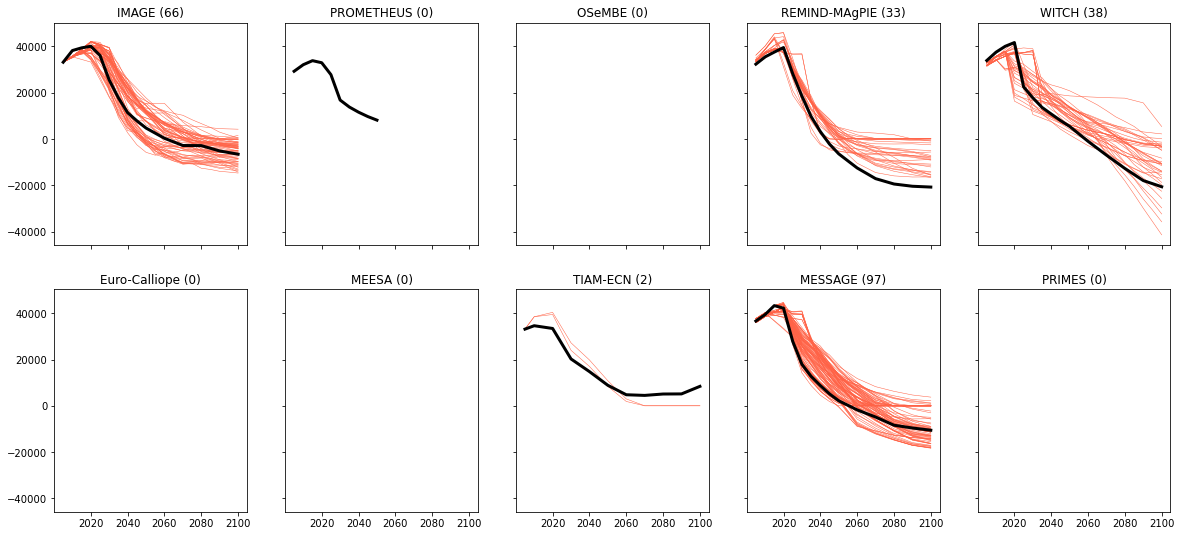

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:16: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:16: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:16: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror
C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_10380\1266247449.py:16: RuntimeWarning: divide by zero encountered in true_divide
  errors = np.array(errors_all[m_i])/maxerror


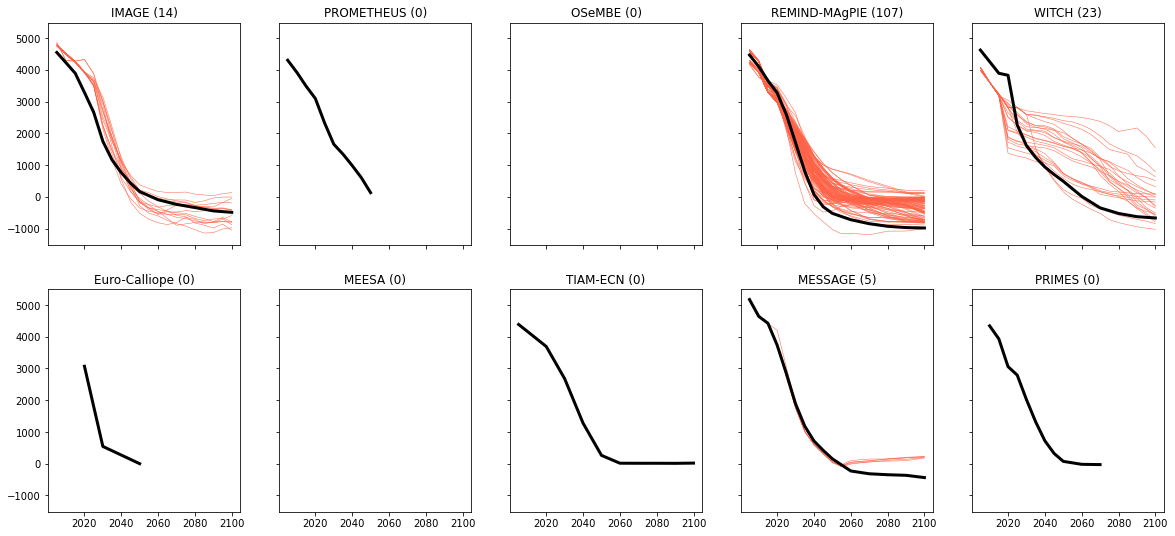

In [11]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(20, 9), sharex=True, sharey=True)
for m_i, m in enumerate(Models_raw):
    ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10][m_i]
    errors = np.array(errors_all[m_i])/maxerror
    for m_ii in range(len(whichmodscens_all[m_i])):
        ax.plot(np.arange(2005, 2101), xr_ar6.sel(Variable="Emissions|CO2", ModelScenario=whichmodscens_all[m_i][m_ii], Time=np.arange(2005, 2101)).Value.T, lw=0.5, color="tomato")
    ax.plot(np.arange(2005, 2101), XRw.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model=Models[m_i]).Value, lw=3, c="k")
    # if m == "MESSAGE":
    #     ax.plot(np.arange(2005, 2101), XRw.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model='IMAGE 3.2').Value, lw=3, c="k")
    ax.set_title(m+' ('+str(len(whichmodscens_all[m_i]))+')')
plt.show()

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(20, 9), sharex=True, sharey=True)
for m_i, m in enumerate(Models_raw):
    ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10][m_i]
    errors = np.array(errors_all[m_i])/maxerror
    for m_ii in range(len(whichmodscens_all_e[m_i])):
        ax.plot(np.arange(2005, 2101), xr_ar6_e.sel(Variable="Emissions|CO2", ModelScenario=whichmodscens_all_e[m_i][m_ii], Time=np.arange(2005, 2101)).Value.T, lw=0.5, color="tomato")
    ax.plot(np.arange(2005, 2101), XRe.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model=Models[m_i]).Value, lw=3, c="k")
    # if m == "MESSAGE":
    #     ax.plot(np.arange(2005, 2101), XRw.sel(Variable="Emissions|CO2", Scenario="DIAG-C400-lin", Model='IMAGE 3.2').Value, lw=3, c="k")
    ax.set_title(m+' ('+str(len(whichmodscens_all_e[m_i]))+')')
plt.show()

## Calculate indicators

In [12]:
emisvar = "Emissions|CO2|Energy and Industrial Processes" #Emissions|CO2|Energy and Industrial Processes
percred = 0.60

A: RAI and speed

In [13]:
XRw = XRw.assign(RAI = (XRw.sel(Variable = emisvar, Scenario="DIAG-Base").Value - XRw.sel(Variable = emisvar).Value) / XRw.sel(Variable = emisvar, Scenario="DIAG-Base").Value)
XRe = XRe.assign(RAI = (XRe.sel(Variable = emisvar, Scenario="DIAG-Base").Value - XRe.sel(Variable = emisvar).Value) / XRe.sel(Variable = emisvar, Scenario="DIAG-Base").Value)
xr_ar6 = xr_ar6.assign(RAI = (XRw.sel(Variable = emisvar, Scenario="DIAG-Base").Value - xr_ar6.sel(Variable = emisvar).Value) / XRw.sel(Variable = emisvar, Scenario="DIAG-Base").Value)
xr_ar6_e = xr_ar6_e.assign(RAI = (XRe.sel(Variable = emisvar, Scenario="DIAG-Base").Value - xr_ar6_e.sel(Variable = emisvar).Value) / XRe.sel(Variable = emisvar, Scenario="DIAG-Base").Value)

In [14]:
initial = np.array(XRw.sel(Variable = emisvar, Scenario="DIAG-C0to80-gr5", Time=2040).Value-XRw.sel(Variable = emisvar, Scenario="DIAG-C80-gr5", Time=2040).Value)
series = np.array(XRw.sel(Variable = emisvar, Scenario="DIAG-C0to80-gr5", Time=np.arange(2040, 2101)).Value)
years = []
for m_i, m in enumerate(XRw.Model):
    wh = np.where(series[m_i] < initial[m_i]*(1-percred))[0]
    if len(wh)>0:
        years.append(np.arange(2040, 2101)[wh[0]]-2040)
    else:
        years.append(np.nan)
XRw = XRw.assign(Timescale = xr.DataArray(data=years, coords=dict(Model=XRw.Model)))

In [15]:
initial = np.array(XRe.sel(Variable = emisvar, Scenario="DIAG-C0to80-gr5", Time=2040).Value-XRe.sel(Variable = emisvar, Scenario="DIAG-C80-gr5", Time=2040).Value)
series = np.array(XRe.sel(Variable = emisvar, Scenario="DIAG-C0to80-gr5", Time=np.arange(2040, 2101)).Value)
years = []
for m_i, m in enumerate(XRe.Model):
    wh = np.where(series[m_i] < initial[m_i]*(1-percred))[0]
    if len(wh)>0:
        years.append(np.arange(2040, 2101)[wh[0]]-2040)
    else:
        years.append(np.nan)
XRe = XRe.assign(Timescale = xr.DataArray(data=[years]*len(scenarios), coords=dict(Scenario=scenarios, Model=XRe.Model)))

In [16]:
#initial = np.array(XRw.sel(Variable = emisvar, Time=2020).Value)
initial = np.array(XRw.sel(Variable = emisvar, Time=np.arange(2020, 2101), Scenario="DIAG-Base").Value)
series = np.array(XRw.sel(Variable = emisvar, Scenario=scenarios, Time=np.arange(2020, 2101)).Value)
years = np.zeros(shape=(len(scenarios), len(Models)))
for m_i, m in enumerate(XRw.Model):
    for s_i, s in enumerate(scenarios):
        wh = np.where(series[s_i, m_i] < initial[m_i]*(1-percred))[0]
        if len(wh)>0:
            years[s_i, m_i] = np.arange(2020, 2101)[wh[0]]-2020
        else:
            years[s_i, m_i] = np.nan
XRw = XRw.assign(RedTimescale = xr.DataArray(data=years, coords=dict(Scenario=scenarios, Model=XRw.Model)))

In [17]:
#initial = np.array(XRe.sel(Variable = emisvar, Time=2020).Value)
initial = np.array(XRe.sel(Variable = emisvar, Time=np.arange(2020, 2101), Scenario="DIAG-Base").Value)
series = np.array(XRe.sel(Variable = emisvar, Scenario=scenarios, Time=np.arange(2020, 2101)).Value)
years = np.zeros(shape=(len(scenarios), len(Models)))
for m_i, m in enumerate(XRe.Model):
    for s_i, s in enumerate(scenarios):
        wh = np.where(series[s_i, m_i] < initial[m_i]*(1-percred))[0]
        if len(wh)>0:
            years[s_i, m_i] = np.arange(2020, 2101)[wh[0]]-2020
        else:
            years[s_i, m_i] = np.nan
XRe = XRe.assign(RedTimescale = xr.DataArray(data=years, coords=dict(Scenario=scenarios, Model=XRe.Model)))

B: ERT vs CCS

In [18]:
XRw = XRw.assign(CI = XRw.sel(Variable = emisvar).Value / XRw.sel(Variable = "Final Energy").Value)
XRe = XRe.assign(CI = XRe.sel(Variable = emisvar).Value / XRe.sel(Variable = "Final Energy").Value)
xr_ar6 = xr_ar6.assign(CI = xr_ar6.sel(Variable = emisvar).Value / xr_ar6.sel(Variable = "Final Energy").Value)
xr_ar6_e = xr_ar6_e.assign(CI = xr_ar6_e.sel(Variable = emisvar).Value / xr_ar6_e.sel(Variable = "Final Energy").Value)

XRw = XRw.assign(EIa = XRw.sel(Variable = "Final Energy").Value)# / XRw.sel(Variable = "GDP|PPP").Value)
XRe = XRe.assign(EIa = XRe.sel(Variable = "Final Energy").Value)# / XRe.sel(Variable = "GDP|PPP").Value)
xr_ar6 = xr_ar6.assign(EIa = xr_ar6.sel(Variable = "Final Energy").Value)# / XRw.sel(Variable = "GDP|PPP").Value)
xr_ar6_e = xr_ar6_e.assign(EIa = xr_ar6_e.sel(Variable = "Final Energy").Value)# / XRw.sel(Variable = "GDP|PPP").Value)

ci_redw = (XRw.CI.sel(Scenario="DIAG-Base") - XRw.CI)/XRw.CI.sel(Scenario="DIAG-Base")
ci_rede = (XRe.CI.sel(Scenario="DIAG-Base") - XRe.CI)/XRe.CI.sel(Scenario="DIAG-Base")
ci_reda = (XRw.CI.sel(Scenario="DIAG-Base") - xr_ar6.CI)/XRw.CI.sel(Scenario="DIAG-Base")
ci_redae = (XRe.CI.sel(Scenario="DIAG-Base") - xr_ar6_e.CI)/XRe.CI.sel(Scenario="DIAG-Base")
ei_redw = (XRw.EIa.sel(Scenario="DIAG-Base") - XRw.EIa)/XRw.EIa.sel(Scenario="DIAG-Base")
ei_rede = (XRe.EIa.sel(Scenario="DIAG-Base") - XRe.EIa)/XRe.EIa.sel(Scenario="DIAG-Base")
ei_reda = (XRw.EIa.sel(Scenario="DIAG-Base") - xr_ar6.EIa)/XRw.EIa.sel(Scenario="DIAG-Base")
ei_redae = (XRe.EIa.sel(Scenario="DIAG-Base") - xr_ar6_e.EIa)/XRe.EIa.sel(Scenario="DIAG-Base")

XRw = XRw.assign(FEred = (XRw.sel(Variable = "Final Energy", Scenario = "DIAG-Base").Value - XRw.sel(Variable = "Final Energy").Value) / XRw.sel(Variable = "Final Energy", Scenario = "DIAG-Base").Value)
XRe = XRe.assign(FEred = (XRe.sel(Variable = "Final Energy", Scenario = "DIAG-Base").Value - XRe.sel(Variable = "Final Energy").Value) / XRe.sel(Variable = "Final Energy", Scenario = "DIAG-Base").Value)

XRw = XRw.assign(CIred = (XRw.CI.sel(Scenario="DIAG-Base") - XRw.CI)/XRw.CI.sel(Scenario="DIAG-Base"))
XRe = XRe.assign(CIred = (XRe.CI.sel(Scenario="DIAG-Base") - XRe.CI)/XRe.CI.sel(Scenario="DIAG-Base"))

XRw = XRw.assign(ERT = ci_redw / (ci_redw+ei_redw))
XRe = XRe.assign(ERT = ci_rede / (ci_rede+ei_rede))
xr_ar6 = xr_ar6.assign(ERT = ci_reda / (ci_reda+ei_reda))
xr_ar6_e = xr_ar6_e.assign(ERT = ci_redae / (ci_redae+ei_redae))

In [19]:
XRw = XRw.assign(CC = XRw.sel(Variable = "Carbon Capture", Time=np.arange(2020, 2051)).Value.sum(dim="Time") / XRw.sel(Variable = emisvar, Time=np.arange(2020, 2051)).Value.sum(dim="Time"))
XRe = XRe.assign(CC = XRe.sel(Variable = "Carbon Capture", Time=np.arange(2020, 2051)).Value.sum(dim="Time") / XRe.sel(Variable = emisvar, Time=np.arange(2020, 2051)).Value.sum(dim="Time"))
xr_ar6 = xr_ar6.assign(CC = xr_ar6.sel(Variable = "Carbon Sequestration|CCS", Time=np.arange(2020, 2051)).Value.sum(dim="Time") / xr_ar6.sel(Variable = emisvar, Time=np.arange(2020, 2051)).Value.sum(dim="Time"))
xr_ar6_e = xr_ar6_e.assign(CC = xr_ar6_e.sel(Variable = "Carbon Sequestration|CCS", Time=np.arange(2020, 2051)).Value.sum(dim="Time") / xr_ar6_e.sel(Variable = emisvar, Time=np.arange(2020, 2051)).Value.sum(dim="Time"))

C: Fossil vs Elec/other in electricity generation

In [20]:
XRw = XRw.assign(ElecFossil = XRw.sel(Variable = ["Secondary Energy|Electricity|Coal",
                                                  "Secondary Energy|Electricity|Oil",
                                                  "Secondary Energy|Electricity|Gas"]).Value.sum(dim="Variable") / XRw.sel(Variable = "Secondary Energy|Electricity").Value)
XRe = XRe.assign(ElecFossil = XRe.sel(Variable = ["Secondary Energy|Electricity|Coal",
                                                  "Secondary Energy|Electricity|Oil",
                                                  "Secondary Energy|Electricity|Gas"]).Value.sum(dim="Variable") / XRe.sel(Variable = "Secondary Energy|Electricity").Value)

xr_ar6 = xr_ar6.assign(ElecFossil = xr_ar6.sel(Variable = ["Secondary Energy|Electricity|Coal",
                                                           "Secondary Energy|Electricity|Oil",
                                                           "Secondary Energy|Electricity|Gas"]).Value.sum(dim="Variable") / xr_ar6.sel(Variable = "Secondary Energy|Electricity").Value)
xr_ar6_e = xr_ar6_e.assign(ElecFossil = xr_ar6_e.sel(Variable = ["Secondary Energy|Electricity|Coal",
                                                                 "Secondary Energy|Electricity|Oil",
                                                                 "Secondary Energy|Electricity|Gas"]).Value.sum(dim="Variable") / xr_ar6_e.sel(Variable = "Secondary Energy|Electricity").Value)

In [21]:
XRw = XRw.assign(ElecVRE_solpv = XRw.sel(Variable = ["Secondary Energy|Electricity|Solar",
                                                "Secondary Energy|Electricity|Wind",
                                                "Secondary Energy|Electricity|Hydro",
                                                "Secondary Energy|Electricity|Geothermal"]).Value.sum(dim="Variable") / XRw.sel(Variable="Secondary Energy|Electricity").Value)
XRe = XRe.assign(ElecVRE = XRe.sel(Variable = ["Secondary Energy|Electricity|Solar",
                                                "Secondary Energy|Electricity|Wind",
                                                "Secondary Energy|Electricity|Hydro",
                                                "Secondary Energy|Electricity|Geothermal"]).Value.sum(dim="Variable") / XRe.sel(Variable="Secondary Energy|Electricity").Value)

XRw = XRw.assign(ElecOther_uni = XRw.sel(Variable = ["Secondary Energy|Electricity|Biomass",
                                                    "Secondary Energy|Electricity|Nuclear",
                                                     "Secondary Energy|Electricity|Other",
                                                    "Secondary Energy|Electricity|Hydrogen"]).Value.sum(dim="Variable") / XRw.sel(Variable="Secondary Energy|Electricity").Value)
XRw = XRw.assign(ElecOther_sep = XRw.sel(Variable = ["Secondary Energy|Electricity|Biomass|w/o CCS",
                                                    "Secondary Energy|Electricity|Biomass|w/ CCS",
                                                    "Secondary Energy|Electricity|Nuclear",
                                                     "Secondary Energy|Electricity|Other",
                                                    "Secondary Energy|Electricity|Hydrogen"]).Value.sum(dim="Variable") / XRw.sel(Variable="Secondary Energy|Electricity").Value)
XRe = XRe.assign(ElecOther_uni = XRe.sel(Variable = ["Secondary Energy|Electricity|Biomass",
                                                     "Secondary Energy|Electricity|Nuclear",
                                                     "Secondary Energy|Electricity|Other",
                                                    "Secondary Energy|Electricity|Hydrogen"]).Value.sum(dim="Variable") / XRe.sel(Variable="Secondary Energy|Electricity").Value)
XRe = XRe.assign(ElecOther_sep = XRe.sel(Variable = ["Secondary Energy|Electricity|Biomass|w/o CCS",
                                                    "Secondary Energy|Electricity|Biomass|w/ CCS",
                                                    "Secondary Energy|Electricity|Nuclear",
                                                     "Secondary Energy|Electricity|Other",
                                                    "Secondary Energy|Electricity|Hydrogen"]).Value.sum(dim="Variable") / XRe.sel(Variable="Secondary Energy|Electricity").Value)

D: Fossil vs elec/other in end-use sectors

In [22]:
XRw = XRw.assign(Fossil_total = (XRw.sel(Variable = ["Final Energy|Gases",
                                                    "Final Energy|Solids",
                                                    "Final Energy|Liquids"]).Value.sum(dim="Variable") - 
                                 XRw.sel(Variable = ["Final Energy|Gases|Biomass",
                                                    "Final Energy|Solids|Biomass",
                                                    "Final Energy|Liquids|Biomass"]).Value.sum(dim="Variable")) / XRw.sel(Variable = "Final Energy").Value)
XRe = XRe.assign(Fossil_total = (XRe.sel(Variable = ["Final Energy|Gases",
                                                    "Final Energy|Solids",
                                                    "Final Energy|Liquids"]).Value.sum(dim="Variable") - 
                                 XRe.sel(Variable = ["Final Energy|Gases|Biomass",
                                                    "Final Energy|Solids|Biomass",
                                                    "Final Energy|Liquids|Biomass"]).Value.sum(dim="Variable")) / XRe.sel(Variable = "Final Energy").Value)

XRw = XRw.assign(Fossil_trans = (XRw.sel(Variable = ["Final Energy|Transportation|Liquids",
                                                    "Final Energy|Transportation|Gases"]).Value.sum(dim="Variable") -
                                XRw.sel(Variable = ["Final Energy|Transportation|Liquids|Biomass",
                                                    "Final Energy|Transportation|Gases|Biomass"]).Value.sum(dim="Variable")) / XRw.sel(Variable = "Final Energy|Transportation").Value)
XRe = XRe.assign(Fossil_trans = (XRe.sel(Variable = ["Final Energy|Transportation|Liquids",
                                                    "Final Energy|Transportation|Gases"]).Value.sum(dim="Variable") -
                                XRe.sel(Variable = ["Final Energy|Transportation|Liquids|Biomass",
                                                    "Final Energy|Transportation|Gases|Biomass"]).Value.sum(dim="Variable")) / XRe.sel(Variable = "Final Energy|Transportation").Value)
XRw = XRw.assign(Fossil_indus = (XRw.sel(Variable = ["Final Energy|Industry|Liquids",
                                                    "Final Energy|Industry|Gases",
                                                    "Final Energy|Industry|Solids"]).Value.sum(dim="Variable") -
                                XRw.sel(Variable = ["Final Energy|Industry|Solids|Biomass"]).Value.sum(dim="Variable")
                                ) / XRw.sel(Variable = "Final Energy|Industry").Value)
XRe = XRe.assign(Fossil_indus = (XRe.sel(Variable = ["Final Energy|Industry|Liquids",
                                                    "Final Energy|Industry|Gases",
                                                    "Final Energy|Industry|Solids"]).Value.sum(dim="Variable") -
                                XRe.sel(Variable = ["Final Energy|Industry|Solids|Biomass"]).Value.sum(dim="Variable")
                                ) / XRe.sel(Variable = "Final Energy|Industry").Value)
XRw = XRw.assign(Fossil_build = (XRw.sel(Variable = ["Final Energy|Residential and Commercial|Liquids",
                                                    "Final Energy|Residential and Commercial|Gases",
                                                    "Final Energy|Residential and Commercial|Solids"]).Value.sum(dim="Variable") -
                                XRw.sel(Variable = ["Final Energy|Residential and Commercial|Liquids|Biomass",
                                                    "Final Energy|Residential and Commercial|Gases|Biomass",
                                                    "Final Energy|Residential and Commercial|Solids|Biomass"]).Value.sum(dim="Variable")
                                                    ) / XRw.sel(Variable = "Final Energy|Residential and Commercial").Value)
XRe = XRe.assign(Fossil_build = (XRe.sel(Variable = ["Final Energy|Residential and Commercial|Liquids",
                                                    "Final Energy|Residential and Commercial|Gases",
                                                    "Final Energy|Residential and Commercial|Solids"]).Value.sum(dim="Variable") -
                                XRe.sel(Variable = ["Final Energy|Residential and Commercial|Liquids|Biomass",
                                                    "Final Energy|Residential and Commercial|Gases|Biomass",
                                                    "Final Energy|Residential and Commercial|Solids|Biomass"]).Value.sum(dim="Variable")
                                ) / XRe.sel(Variable = "Final Energy|Residential and Commercial").Value)

In [23]:
XRw = XRw.assign(Elec_total = (XRw.sel(Variable = ["Final Energy|Electricity"]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy").Value)
XRw = XRw.assign(Other_total = (XRw.sel(Variable = ["Final Energy|Hydrogen",
                                                    "Final Energy|Liquids|Biomass",
                                                    "Final Energy|Gases|Biomass",
                                                    "Final Energy|Solids|Biomass",
                                                    "Final Energy|Geothermal",
                                                    "Final Energy|Solar",
                                                    "Final Energy|Heat",]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy").Value)
XRe = XRe.assign(Elec_total = (XRe.sel(Variable = ["Final Energy|Electricity"]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy").Value)
XRe = XRe.assign(Other_total = (XRe.sel(Variable = ["Final Energy|Hydrogen",
                                                    "Final Energy|Liquids|Biomass",
                                                    "Final Energy|Gases|Biomass",
                                                    "Final Energy|Solids|Biomass",
                                                    "Final Energy|Geothermal",
                                                    "Final Energy|Solar",
                                                    "Final Energy|Heat",]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy").Value)


XRw = XRw.assign(Elec_trans = (XRw.sel(Variable = ["Final Energy|Transportation|Electricity"]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy|Transportation").Value)
XRw = XRw.assign(Other_trans = (XRw.sel(Variable = ["Final Energy|Transportation|Hydrogen", "Final Energy|Transportation|Liquids|Biomass", "Final Energy|Transportation|Gases|Biomass"]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy|Transportation").Value)
XRe = XRe.assign(Elec_trans = (XRe.sel(Variable = ["Final Energy|Transportation|Electricity"]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy|Transportation").Value)
XRe = XRe.assign(Other_trans = (XRe.sel(Variable = ["Final Energy|Transportation|Hydrogen", "Final Energy|Transportation|Liquids|Biomass", "Final Energy|Transportation|Gases|Biomass"]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy|Transportation").Value)


XRw = XRw.assign(Elec_indus = (XRw.sel(Variable = ["Final Energy|Industry|Electricity"]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy|Industry").Value)
XRw = XRw.assign(Other_indus = (XRw.sel(Variable = ["Final Energy|Industry|Heat", "Final Energy|Industry|Hydrogen", "Final Energy|Industry|Solids|Biomass"]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy|Industry").Value)
XRe = XRe.assign(Elec_indus = (XRe.sel(Variable = ["Final Energy|Industry|Electricity"]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy|Industry").Value)
XRe = XRe.assign(Other_indus = (XRe.sel(Variable = ["Final Energy|Industry|Heat", "Final Energy|Industry|Hydrogen", "Final Energy|Industry|Solids|Biomass"]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy|Industry").Value)
                                                    

XRw = XRw.assign(Elec_build = (XRw.sel(Variable = ["Final Energy|Residential and Commercial|Electricity"]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy|Residential and Commercial").Value)
XRw = XRw.assign(Other_build = (XRw.sel(Variable = ["Final Energy|Residential and Commercial|Other", "Final Energy|Residential and Commercial|Heat", "Final Energy|Residential and Commercial|Hydrogen","Final Energy|Residential and Commercial|Solids|Biomass","Final Energy|Residential and Commercial|Liquids|Biomass","Final Energy|Residential and Commercial|Gases|Biomass"]).Value.sum(dim="Variable"))/XRw.sel(Variable="Final Energy|Residential and Commercial").Value)
XRe = XRe.assign(Elec_build = (XRe.sel(Variable = ["Final Energy|Residential and Commercial|Electricity"]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy|Residential and Commercial").Value)
XRe = XRe.assign(Other_build = (XRe.sel(Variable = ["Final Energy|Residential and Commercial|Other", "Final Energy|Residential and Commercial|Heat", "Final Energy|Residential and Commercial|Hydrogen", "Final Energy|Residential and Commercial|Solids|Biomass","Final Energy|Residential and Commercial|Liquids|Biomass", "Final Energy|Residential and Commercial|Gases|Biomass"]).Value.sum(dim="Variable"))/XRe.sel(Variable="Final Energy|Residential and Commercial").Value)


## Save XR

In [24]:
XRe.to_netcdf("X:/user/dekkerm/Projects/ECEMF/WP1/Data/XRe.nc")
XRw.to_netcdf("X:/user/dekkerm/Projects/ECEMF/WP1/Data/XRw.nc")

## Figures

In [25]:
world_or_europe = "Europe"
if world_or_europe == "Europe":
    XR_i = XRe
else:
    XR_i = XRw

In [26]:
def from_col_to_rgb(colname, alpha):
    x1, x2, x3, _ = colors.to_rgba(ModelCols[m_i])
    return "rgba("+str(x1*255)+","+str(x2*255)+","+str(x3*255)+","+str(alpha)+")"

In [27]:
c400lins = ['DIAG-C400-lin-LimBio',
                        'DIAG-C400-lin-LimCCS',
                        'DIAG-C400-lin-LimNuclear',
                        'DIAG-C400-lin-HighVRE',
                        'DIAG-C400-lin-HighElectrification',
                        'DIAG-C400-lin-HighH2',
                        'DIAG-C400-lin-ResidualFossil',
                        'DIAG-C400-lin-HighEff',
                        "DIAG-C400-lin"]

## Plot I: Sensitivity

In [48]:
var_x = XR_i.RedTimescale.sel(Model=Models_noec)
var_y = XR_i.RAI.sel(Time=2050, Model=Models_noec)

fig = make_subplots(rows=1, cols=1,
                horizontal_spacing = 0.08, vertical_spacing=0.12)

for m_i, m in enumerate(Models_noec):
        for s in ['DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-LimCCS',
                'DIAG-C400-lin-LimNuclear',
                'DIAG-C400-lin-HighVRE',
                'DIAG-C400-lin-HighElectrification',
                'DIAG-C400-lin-HighH2',
                'DIAG-C400-lin-ResidualFossil',
                'DIAG-C400-lin-HighEff']:
                t = ""
                if s in ['DIAG-C400-lin-LimBio',
                #'DIAG-C400-lin-HighElectrification',
                'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                'DIAG-C400-lin-LimCCS',
                'DIAG-C400-lin-HighEff']: t = s[14:]
                fig.add_trace(go.Scatter(x=[var_x.sel(Scenario="DIAG-C400-lin", Model=m), var_x.sel(Scenario=s, Model=m)],
                                        y=[var_y.sel(Scenario="DIAG-C400-lin", Model=m), var_y.sel(Scenario=s, Model=m)], name=m,
                                        mode='lines+markers+text',
                                        showlegend=False,
                                        line={'width': 2, 'dash': 'solid'},
                                        text=["", t],
                                        textfont = dict(color=ModelCols_noec[m_i], size=15),
                                        hovertemplate='<b>%{text}</b> <br>'+"RAI"+': %{y:.2f} <br>'+"Timescale"+': %{x:.2f}',
                                        marker={"color": ModelCols_noec[m_i],
                                                "size": 10,
                                                "line": {"color": "black", "width": 1}}
                                        ), 1, 1)
                                        
for m_i, m in enumerate(Models_noec):
        fig.add_trace(go.Scatter(x=[var_x.sel(Scenario="DIAG-C400-lin", Model=m)],
                                y=[var_y.sel(Scenario="DIAG-C400-lin", Model=m)],
                                mode='markers',
                                showlegend=True, line_width=4,
                                name=Models_raw_noec[m_i],
                                text="DIAG-C400-lin",
                                hovertemplate='<b>DIAG-C400-lin</b> <br>'+"RAI"+': %{y:.2f} <br>'+"Timescale"+': %{x:.2f}',
                                marker={"color": ModelCols_noec[m_i],
                                        "size": 20,
                                        "line": {"color": "black", "width": 4}}
                                ), 1, 1)

fig.update_xaxes(row=1, col=1, title="Years until 60% reduction in CO2 emissions w.r.t. base", title_font_size=25)#, range=(7, 23))
fig.update_yaxes(row=1, col=1, title="Relative abatement index (RAI) in 2050", title_font_size=25)

fig.update_traces(textposition='top center')
fig.update_annotations(font_size=15)
fig.update_layout(legend=dict(x=0.05, y=1.05, orientation="h", font_size=15))
fig.update_layout(height=900, width=1500)#autosize=True)
fig.update_layout(template="ggplot2")
fig.show()
fig_sens_ls = fig

In [29]:
var_x = XR_i.Time
var_y = XR_i.Value.sel(Variable=emisvar)

fig = make_subplots(rows=1, cols=1,
                horizontal_spacing = 0.08, vertical_spacing=0.12)
                                        
for m_i, m in enumerate(Models):
        fig.add_trace(go.Scatter(x=var_x,
                                y=var_y.sel(Model=m, Scenario="DIAG-Base"),
                                mode='lines',
                                showlegend=False, line_width=4,
                                name=Models_raw[m_i],
                                marker={"color": ModelCols[m_i],
                                        "size": 20,
                                        "line": {"color": "black", "width": 4}}
                                ), 1, 1)
        fig.add_trace(go.Scatter(x=var_x,
                                y=var_y.sel(Model=m, Scenario="DIAG-C400-lin"),
                                mode='lines',
                                showlegend=False, line_width=4,
                                name=Models_raw[m_i],
                                line=dict(dash='dot'),
                                marker={"color": ModelCols[m_i],
                                        "size": 20,
                                        "line": {"color": "black", "width": 4}}
                                ), 1, 1)

fig.update_xaxes(row=1, col=1, title="Time (year)", title_font_size=25)#, range=(7, 23))
fig.update_yaxes(row=1, col=1, title="CO2 emissions from E&I", title_font_size=25)

fig.update_traces(textposition='top center')
fig.update_annotations(font_size=15)
fig.update_layout(legend=dict(x=0.05, y=1.05, orientation="h", font_size=15))
fig.update_layout(height=900, width=700)#autosize=True)
fig.update_layout(template="ggplot2")
fig.show()
fig_sens_em = fig

In [30]:
vars_x = XR_i.RedTimescale.sel(Model=Models)
vars_y = XR_i.RAI.sel(Time=2050, Model=Models)

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("<b>(a) HighEff",
                                    "<b>(b) HighVRE",
                                    "<b>(c) LimBio",
                                    "<b>(d) LimCCS"),
                    horizontal_spacing = 0.02, vertical_spacing=0.04, shared_xaxes=True, shared_yaxes=True)

# # Shapes / backgrounds
whichscens = ['DIAG-C400-lin-HighEff',
              'DIAG-C400-lin-HighVRE',
              'DIAG-C400-lin-LimBio',
              'DIAG-C400-lin-LimCCS',
              ]

XRx = vars_x
XRy = vars_y
for s_i, s in enumerate(whichscens):
        row = [1, 1, 2, 2][s_i]
        col = [1, 2, 1, 2][s_i]
        fig.add_trace(go.Scatter(x=[-100, 100], y=[0, 0], line={'width':0.5, 'color': 'black'}, showlegend=False), row, col)
        fig.add_trace(go.Scatter(x=[0, 0], y=[-100, 100], line={'width':0.5, 'color': 'black'}, showlegend=False), row, col)
        for m_i, m in enumerate(Models):
                X = float(XRx.sel(Scenario=s, Model=m) - XRx.sel(Scenario="DIAG-C400-lin", Model=m))
                Y = float(XRy.sel(Scenario=s, Model=m) - XRy.sel(Scenario="DIAG-C400-lin", Model=m))
                fig.add_trace(go.Scatter(x=[0, X],
                                        y=[0, Y], name=m, mode='markers+lines',
                                        showlegend=[True, False, False, False][s_i],
                                        line={'width': 2, 'dash': 'solid', 'color': 'black', 'color': ModelCols[m_i]},
                                        marker={'size': 15, 'color': ModelCols[m_i], 'line': {'color': 'black', 'width': 1}},
                                        text=m,
                                        ), row, col)
        # nonans = np.where((~np.isnan(X)) & (~np.isnan(Y)))[0]
        # points = np.array([X[nonans], Y[nonans]]).T

        # if len(points) > 2 and np.sum(points[:, 0]) > 0:
        #         tri = Delaunay(points)
        #         poss = np.array(tri.vertices)
        #         c = list(colors.to_rgba('steelblue'))
        #         c[3] = 0.3
        #         c = 'rgba'+str(tuple(c))
        #         for r123 in poss:
        #                 fig.add_trace(go.Scatter(x=X[nonans[r123]],
        #                                         y=Y[nonans[r123]], name="", mode='markers',
        #                                         showlegend=False,
        #                                         line={'width': 1, 'dash': 'solid'},
        #                                         text=[s+' ('+i+')' for i in np.array(XR_i.Model)[nonans[r123]]],
        #                                         fill="toself",
        #                                         fillcolor=c,
        #                                         hoverinfo='skip',
        #                                         marker={"color": 'grey',
        #                                                 "size": 1,
        #                                                 "line": {"color": "black", "width": 0}}
        #                                         ), row, col)
        #         poss_hull = np.array(tri.convex_hull)
        #         for r12 in poss_hull:
        #                 fig.add_trace(go.Scatter(x=X[nonans[r12]],
        #                                         y=Y[nonans[r12]], name="", mode='lines',
        #                                         showlegend=False,
        #                                         line={'width': 1, 'dash': 'solid', 'color': 'steelblue'},
        #                                         text="",
        #                                         hoverinfo='skip',
        #                                         ), row, col)

for s_i, s in enumerate(whichscens):
        row = [1, 1, 2, 2][s_i]
        col = [1, 2, 1, 2][s_i]

        X = np.array(XRx.sel(Scenario=s) - XRx.sel(Scenario="DIAG-C400-lin"))
        Y = np.array(XRy.sel(Scenario=s) - XRy.sel(Scenario="DIAG-C400-lin"))
        nonans = np.where((~np.isnan(X)) & (~np.isnan(Y)))[0]
        xmetric = float(np.mean(X[nonans]))
        ymetric = float(np.mean(Y[nonans]))
        fig.add_trace(go.Scatter(x=[xmetric],
                                y=[ymetric], name=s[14:], mode='markers',
                                showlegend=False,
                                line={'width': 1, 'dash': 'solid'},
                                text=[s[14:]],
                                textfont={'size':15, 'color':'black'},
                                marker={"color": 'white',
                                        "symbol": 'diamond', 
                                        "size": 15,
                                        "line": {"color": 'black', "width": 5}}
                                ), row, col)

fig.update_xaxes(row=2, col=1, title="Years until 60% reduction in CO2 emissions w.r.t. base<br>Deviation", range=(-5, 5))
fig.update_xaxes(row=2, col=2, title="Years until 60% reduction in CO2 emissions w.r.t. base<br>Deviation", range=(-5, 5))
fig.update_yaxes(row=1, col=1, title="Relative abatement index (RAI) in 2050<br>Percentage-point deviation", range=(-0.2, 0.2))
fig.update_yaxes(row=2, col=1, title="Relative abatement index (RAI) in 2050<br>Percentage-point deviation", range=(-0.2, 0.2))

fig.update_annotations(font_size=18)
fig.update_layout(legend=dict(x=0.05, y=1.15, orientation="h", font_size=15))
fig.update_layout(height=900, width=1500)#autosize=True)
fig.update_layout(template="ggplot2")
fig.show()
fig_sens_dev = fig

## Plot II: Mitigation

In [31]:
times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.Value.sel(Variable='Carbon Capture', Model=Models)/5000
var_y = XR_i.CIred.sel(Model=Models)
var_z = XR_i.FEred.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    a = float(var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"))
    b = float(var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"))
    c = float(var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"))
    for scen in c400lins:
                a2 = float(var_x.sel(Time=times, Model=m, Scenario=scen))
                b2 = float(var_y.sel(Time=times, Model=m, Scenario=scen))
                c2 = float(var_z.sel(Time=times, Model=m, Scenario=scen))
                trace = go.Scatterternary(a=[a, a2],
                                        b=[b, b2],
                                        c=[c, c2],
                                        name=m,
                                        text=["DIAG-C400-lin", scen],
                                        mode='markers+lines',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
#                 trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
#                                         b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
#                                         c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
#                                         name=m,
#                                         text=["DIAG-C400-lin", scen],
#                                         mode='markers+lines',
#                                         showlegend=False,
#                                         marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
#                 traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)

fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
'aaxis':{'title': '<b>Carbon Capture</b><br>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['5 Gt CO2', '6 Gt CO2', '7 Gt CO2', '8 Gt CO2', '9 Gt CO2', '10 Gt CO2'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>Carbon Intensity &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;<br>reduction &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;</b>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Final Energy<br>reduction</b>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_layout(legend=dict(x=0.02, y=0.95, orientation="v"))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()

In [49]:
var_x = XR_i.CIred.sel(Time=2050, Model=Models_noec)
var_y = XR_i.FEred.sel(Time=2050, Model=Models_noec)

fig = make_subplots(rows=1, cols=1,
                horizontal_spacing = 0.08, vertical_spacing=0.12)

for m_i, m in enumerate(Models_noec):
        for s in ['DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-LimCCS',
                'DIAG-C400-lin-LimNuclear',
                'DIAG-C400-lin-HighVRE',
                'DIAG-C400-lin-HighElectrification',
                'DIAG-C400-lin-HighH2',
                'DIAG-C400-lin-ResidualFossil',
                'DIAG-C400-lin-HighEff']:
                t = ""
                if s in ['DIAG-C400-lin-LimBio',
                #'DIAG-C400-lin-HighElectrification',
                'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                'DIAG-C400-lin-LimCCS',
                'DIAG-C400-lin-HighEff']: t = s[14:]
                fig.add_trace(go.Scatter(x=[var_x.sel(Scenario="DIAG-C400-lin", Model=m), var_x.sel(Scenario=s, Model=m)],
                                        y=[var_y.sel(Scenario="DIAG-C400-lin", Model=m), var_y.sel(Scenario=s, Model=m)], name=m,
                                        mode='lines+markers+text',
                                        showlegend=False,
                                        line={'width': 2, 'dash': 'solid'},
                                        text=["", t],
                                        textfont = dict(color=ModelCols_noec[m_i], size=15),
                                        marker={"color": ModelCols_noec[m_i],
                                                "size": 10,
                                                "line": {"color": "black", "width": 1}}
                                        ), 1, 1)
                                        
for m_i, m in enumerate(Models_noec):
        fig.add_trace(go.Scatter(x=[var_x.sel(Scenario="DIAG-C400-lin", Model=m)],
                                y=[var_y.sel(Scenario="DIAG-C400-lin", Model=m)],
                                mode='markers',
                                showlegend=True, line_width=4,
                                name=Models_raw_noec[m_i],
                                text="DIAG-C400-lin",
                                hovertemplate='<b>DIAG-C400-lin</b> <br>'+"ERT"+': %{y:.2f} <br>'+"Carbon capture"+': %{x:.2f}',
                                marker={"color": ModelCols_noec[m_i],
                                        "size": 20,
                                        "line": {"color": "black", "width": 4}}
                                ), 1, 1)

fig.update_xaxes(row=1, col=1, title="Carbon Intensity Reduction", title_font_size=25)
fig.update_yaxes(row=1, col=1, title="Final Energy Reduction", title_font_size=25)

fig.update_traces(textposition='top center')
fig.update_annotations(font_size=18)
fig.update_layout(legend=dict(x=0.05, y=1.05, orientation="h", font_size=15))
fig.update_layout(height=900, width=1500)#autosize=True)
fig.update_layout(template="ggplot2")
fig.show()
fig_mit_ls = fig

In [33]:
var_x = XR_i.Time
var_y = XR_i.Value.sel(Variable="Carbon Capture")

fig = make_subplots(rows=1, cols=1,
                horizontal_spacing = 0.08, vertical_spacing=0.12)
                                        
for m_i, m in enumerate(Models):
        fig.add_trace(go.Scatter(x=var_x,
                                y=var_y.sel(Model=m, Scenario="DIAG-Base"),
                                mode='lines',
                                showlegend=False, line_width=4,
                                name=Models_raw[m_i],
                                marker={"color": ModelCols[m_i],
                                        "size": 20,
                                        "line": {"color": "black", "width": 4}}
                                ), 1, 1)
        fig.add_trace(go.Scatter(x=var_x,
                                y=var_y.sel(Model=m, Scenario="DIAG-C400-lin"),
                                mode='lines',
                                showlegend=False, line_width=4,
                                name=Models_raw[m_i],
                                line=dict(dash='dot'),
                                marker={"color": ModelCols[m_i],
                                        "size": 20,
                                        "line": {"color": "black", "width": 4}}
                                ), 1, 1)

fig.update_xaxes(row=1, col=1, title="Time (year)", title_font_size=25)#, range=(7, 23))
fig.update_yaxes(row=1, col=1, title="Carbon Capture (Mt CO2/yr)", title_font_size=25)

fig.update_traces(textposition='top center')
fig.update_annotations(font_size=15)
fig.update_layout(legend=dict(x=0.05, y=1.05, orientation="h", font_size=15))
fig.update_layout(height=900, width=700)#autosize=True)
fig.update_layout(template="ggplot2")
fig.show()
fig_mit_cc = fig

## Plot IIIa: Electricity mix (time)

In [34]:
times = [2020, 2050]
times_long = np.arange(2020, 2051, 5)
scen = "DIAG-C400-lin"
var_x = XR_i.ElecFossil.sel(Model=Models)
var_y = XR_i.ElecVRE.sel(Model=Models)
var_z_uni = XR_i.ElecOther_uni.sel(Model=Models)
var_z_sep = XR_i.ElecOther_sep.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    if m_i != 0: var_z = var_z_uni
    else: var_z = var_z_sep
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=scen),
                              b=var_y.sel(Time=times, Model=m, Scenario=scen),
                              c=var_z.sel(Time=times, Model=m, Scenario=scen),
                              name=m,
                              mode='markers',
                              marker={"color": col, "size": 10})
    traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times_long, Model=m, Scenario=scen),
                              b=var_y.sel(Time=times_long, Model=m, Scenario=scen),
                              c=var_z.sel(Time=times_long, Model=m, Scenario=scen),
                              name=m,
                              showlegend=False,
                              mode='lines',
                              marker={"color": col, "size": 10})
    traces.append(trace)

fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>VRE<br>(incl. geothermal)</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass+nuclear)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_layout(legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()

## Plot IIIb: Electricity mix (c400 variations)

In [50]:
times = [2030]
scen = "DIAG-C400-lin"
var_x = XR_i.ElecFossil.sel(Model=Models)
var_y = XR_i.ElecVRE.sel(Model=Models)
var_z_uni = XR_i.ElecOther_uni.sel(Model=Models)
var_z_sep = XR_i.ElecOther_sep.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    if m_i != 0: var_z = var_z_uni
    else: var_z = var_z_sep
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>VRE<br>(incl. geothermal)</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass+nuclear)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_elec_2030 = fig

## 2050 VERSION
times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.ElecFossil.sel(Model=Models)
var_y = XR_i.ElecVRE.sel(Model=Models)
var_z_uni = XR_i.ElecOther_uni.sel(Model=Models)
var_z_sep = XR_i.ElecOther_sep.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    if m_i != 0: var_z = var_z_uni
    else: var_z = var_z_sep
    for scen in c400lins:
                t = ""
                if scen in ['DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-HighElectrification',
                'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                #'DIAG-C400-lin-LimCCS',
                #'DIAG-C400-lin-HighEff'
                ]: t = scen[14:]
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", t],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>VRE<br>(incl. geothermal)</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass+nuclear)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_elec_2050 = fig

In [60]:
## 2050 VERSION
times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.ElecFossil.sel(Model=Models)
var_y = XR_i.ElecVRE.sel(Model=Models)
var_z_uni = XR_i.ElecOther_uni.sel(Model=Models)
var_z_sep = XR_i.ElecOther_sep.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    if m_i != 0: var_z = var_z_uni
    else: var_z = var_z_sep
    for scen in ['DIAG-C400-lin-HighElectrification']:
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", ""],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 14, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>VRE<br>(incl. geothermal)</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass+nuclear)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>HighElectrification", title_font_size=25,  legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_elec_2050_highelec = fig

In [59]:
## 2050 VERSION
times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.ElecFossil.sel(Model=Models)
var_y = XR_i.ElecVRE.sel(Model=Models)
var_z_uni = XR_i.ElecOther_uni.sel(Model=Models)
var_z_sep = XR_i.ElecOther_sep.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    if m_i != 0: var_z = var_z_uni
    else: var_z = var_z_sep
    for scen in ['DIAG-C400-lin-HighVRE']:
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", ""],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 14, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>VRE<br>(incl. geothermal)</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass+nuclear)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>HighVRE", title_font_size=25,  legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_elec_2050_highvre = fig

In [62]:
## 2050 VERSION
times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.ElecFossil.sel(Model=Models)
var_y = XR_i.ElecVRE.sel(Model=Models)
var_z_uni = XR_i.ElecOther_uni.sel(Model=Models)
var_z_sep = XR_i.ElecOther_sep.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    if m_i != 0: var_z = var_z_uni
    else: var_z = var_z_sep
    for scen in ['DIAG-C400-lin-LimBio']:
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", ""],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 14, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>VRE<br>(incl. geothermal)</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass+nuclear)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>LimBio", title_font_size=25,  legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_elec_2050_limbio = fig

In [63]:
## 2050 VERSION
times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.ElecFossil.sel(Model=Models)
var_y = XR_i.ElecVRE.sel(Model=Models)
var_z_uni = XR_i.ElecOther_uni.sel(Model=Models)
var_z_sep = XR_i.ElecOther_sep.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    if m_i != 0: var_z = var_z_uni
    else: var_z = var_z_sep
    for scen in ['DIAG-C400-lin-LimCCS']:
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", ""],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 14, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>VRE<br>(incl. geothermal)</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass+nuclear)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>LimCCS", title_font_size=25,  legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_elec_2050_limccs = fig

## Plot IVa: End-use industry

In [36]:
times = [2030]
scen = "DIAG-C400-lin"
var_x = XR_i.Fossil_indus.sel(Model=Models)
var_y = XR_i.Elec_indus.sel(Model=Models)
var_z = XR_i.Other_indus.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    for scen in c400lins:
                t = ""
                if scen in [#'DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-HighElectrification',
                #'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                #'DIAG-C400-lin-LimCCS',
                #'DIAG-C400-lin-HighEff'
                ]: t = scen[14:]
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", t],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>Electricity</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass, H2, heat)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>Industry", title_font_size=25, legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_indus_2030 = fig

####
times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.Fossil_indus.sel(Model=Models)
var_y = XR_i.Elec_indus.sel(Model=Models)
var_z = XR_i.Other_indus.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    for scen in c400lins:
                t = ""
                if scen in [#'DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-HighElectrification',
                #'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                #'DIAG-C400-lin-LimCCS',
                #'DIAG-C400-lin-HighEff'
                ]: t = scen[14:]
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", t],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>Electricity</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass, H2, heat)</b>', 'min': 0, 'titlefont':{'size': 20},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>Industry", title_font_size=25, legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_indus_2050 = fig

## Plot IVb: End-use Transport

In [37]:
times = [2030]
scen = "DIAG-C400-lin"
var_x = XR_i.Fossil_trans.sel(Model=Models)
var_y = XR_i.Elec_trans.sel(Model=Models)
var_z = XR_i.Other_trans.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    for scen in c400lins:
                t = ""
                if scen in [#'DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-HighElectrification',
                #'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                #'DIAG-C400-lin-LimCCS',
                #'DIAG-C400-lin-HighEff'
                ]: t = scen[14:]
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", t],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>Electricity</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass, H2, heat)</b>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>Transport", title_font_size=25, legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_trans_2030 = fig

##

times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.Fossil_trans.sel(Model=Models)
var_y = XR_i.Elec_trans.sel(Model=Models)
var_z = XR_i.Other_trans.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    for scen in c400lins:
                t = ""
                if scen in [#'DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-HighElectrification',
                #'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                #'DIAG-C400-lin-LimCCS',
                #'DIAG-C400-lin-HighEff'
                ]: t = scen[14:]
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", t],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>Electricity</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass, H2, heat)</b>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>Transport", title_font_size=25, legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_trans_2050 = fig

## Plot IVc: End-use Buildings

In [38]:
times = [2030]
scen = "DIAG-C400-lin"
var_x = XR_i.Fossil_build.sel(Model=Models)
var_y = XR_i.Elec_build.sel(Model=Models)
var_z = XR_i.Other_build.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    for scen in c400lins:
                t = ""
                if scen in [#'DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-HighElectrification',
                #'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                #'DIAG-C400-lin-LimCCS',
                #'DIAG-C400-lin-HighEff'
                ]: t = scen[14:]
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", t],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>Electricity</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass, H2, heat)</b>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>Buildings", title_font_size=25, legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_build_2030 = fig

##

times = [2050]
scen = "DIAG-C400-lin"
var_x = XR_i.Fossil_build.sel(Model=Models)
var_y = XR_i.Elec_build.sel(Model=Models)
var_z = XR_i.Other_build.sel(Model=Models)

traces = []
for m_i, m in enumerate(Models):
    col = ModelCols[m_i]
    for scen in c400lins:
                t = ""
                if scen in [#'DIAG-C400-lin-LimBio',
                'DIAG-C400-lin-HighElectrification',
                #'DIAG-C400-lin-HighVRE',
                #'DIAG-C400-lin-ResidualFossil'
                #'DIAG-C400-lin-LimCCS',
                #'DIAG-C400-lin-HighEff'
                ]: t = scen[14:]
                trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        b=var_y.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        c=var_z.sel(Time=times, Model=m, Scenario=["DIAG-C400-lin", scen]).T[0],
                                        name=m,
                                        text=["", t],
                                        textfont = dict(color=ModelCols[m_i], size=15),
                                        mode='markers+lines+text',
                                        showlegend=False,
                                        marker={"color": col, "size": 8, 'line': dict(width=1, color='black')})
                traces.append(trace)
    trace = go.Scatterternary(a=var_x.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                b=var_y.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                c=var_z.sel(Time=times, Model=m, Scenario="DIAG-C400-lin"),
                                name=m,
                                mode='markers+lines',
                                text = "DIAG-C400-lin",
                                showlegend=True,
                                marker={"color": col, "size": 20, 'line': dict(width=3, color='black')})
    traces.append(trace)
        
fig = make_subplots(rows=1, cols=1, horizontal_spacing = 0.08, vertical_spacing=0.12)
for t in traces:
    fig.add_trace(t)
fig.update_layout(height=900, width=1200)
fig.update_layout({#'margin':dict(l=0,r=7,b=0,t=35),
'plot_bgcolor':'rgb(243, 243, 243)',
'ternary':
{'sum':1,
# 'bgcolor':'rgba(0,0,0,0)',#'whitesmoke',
#     # "paper_bgcolor":'rgba(0,0,0,0)',
#     # "plot_bgcolor":'rgba(0,0,0,0)',
'aaxis':{'title': '<b>Fossil</b><br>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':0, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'], 'tickfont':{'size':15}},
'baxis':{'title': '<b>Electricity</b> &nbsp; &nbsp; &nbsp;', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':60, 'tickfont':{'size':15}},
'caxis':{'title': '<b>Other<br>(biomass, H2, heat)</b>', 'min': 0, 'titlefont':{'size': 16},
        'linewidth':2, 'ticks':'outside',
        'tickmode':'array','tickvals':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'ticktext':['50%', '60%', '70%', '80%', '90%', '100%'],'tickangle':-60, 'tickfont':{'size':15}}}})

fig.update_traces(textposition='top center')
fig.update_layout(title="<b>Buildings", title_font_size=25, legend=dict(x=0.02, y=0.95, orientation="v", font_size=16))
fig.update_annotations(font_size=15)
fig.update_layout(template="ggplot2")
fig.show()
fig_build_2050 = fig

## Savings

In [64]:
figs = [fig_sens_ls,
fig_sens_em,
fig_sens_dev,
fig_mit_ls,
fig_mit_cc,
fig_elec_2030,
fig_elec_2050,
fig_indus_2030,
fig_indus_2050,
fig_trans_2030,
fig_trans_2050,
fig_build_2030,
fig_build_2050]

fignames = ("fig_sens_ls fig_sens_em fig_sens_dev fig_mit_ls fig_mit_cc fig_elec_2030 fig_elec_2050 fig_indus_2030 fig_indus_2050 fig_trans_2030 fig_trans_2050 fig_build_2030 fig_build_2050").split(' ')

In [40]:
# path_figs = Path("X:/user/dekkerm/Projects/ECEMF/WP1/Figures")

# try:
#     os.remove(path_figs / 'LandscapeFigures/Landscapes_ind.html')
# except:
#     3
# def html_w(typ):
#     return '<html> '+typ+' <p style="font-family: Arial">'

# today = date.today()
# td = today.strftime("%B %d, %Y")

# with open(path_figs / 'LandscapeFigures/Landscapes_ind.html', 'a') as f:
#     f.write(html_w('<h1>')+'Diagnostic indicator landscape figures</p></h1>')
#     f.write(html_w('<body>')+'Version: '+td+'</p></body>')

#     for n_i in range(len(figs)):
#         if n_i > 0:
#             f.write('<hr>')
#         f.write(html_w('<h1>')+'Fig. '+str(n_i+1)+'</p></h1>')
#         f.write(html_w('<body>')+'</p></body>')
#         f.write(figs[n_i].to_html(full_html=False, include_plotlyjs='cdn'))

In [65]:
for fig_i, fig in enumerate(figs):
    fig.write_image("X:/user/dekkerm/Projects/ECEMF/WP1/Figures/LandscapeFigures/"+fignames[fig_i]+".svg")
# fig_landscape_d.write_image("X:/user/dekkerm/Projects/ECEMF/WP1/Figures/LandscapeFigures/Fig_landscape_d.png", scale=3)